
## How various NLP methodologies, particularly topic modeling, can be leveraged to analyze customer reviews for hotels ?

In [68]:
# Loading libraries
library(tidyverse) 
library(tidytext) 
library(topicmodels) 
library(tm) 
library(SnowballC) 
library(RColorBrewer)
library(ggplot2)
library(readr)



In [ ]:
reviews <- read_csv("~/Downloads/deceptive-opinion.csv")


# Topic modeling(LDA)

In [70]:
# Pre-processing text 
reviewsCorpus <- Corpus(VectorSource(reviews$text)) 
reviewsDTM <- DocumentTermMatrix(reviewsCorpus)

reviewsDTM_tidy <- tidy(reviewsDTM)

custom_stop_words <- tibble(word = c("hotel", "room"))

reviewsDTM_tidy_cleaned <- reviewsDTM_tidy %>% 
    anti_join(stop_words, by = c("term" = "word")) %>% 
    anti_join(custom_stop_words, by = c("term" = "word")) 

reviewsDTM_tidy_cleaned <- reviewsDTM_tidy_cleaned %>% 
    mutate(stem = wordStem(term))
cleaned_documents <- reviewsDTM_tidy_cleaned %>%
    group_by(document) %>% 
    mutate(terms = toString(rep(stem, count))) %>%
    select(document, terms) %>%
    unique()

Warning message in brewer.pal(number_of_topics, "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

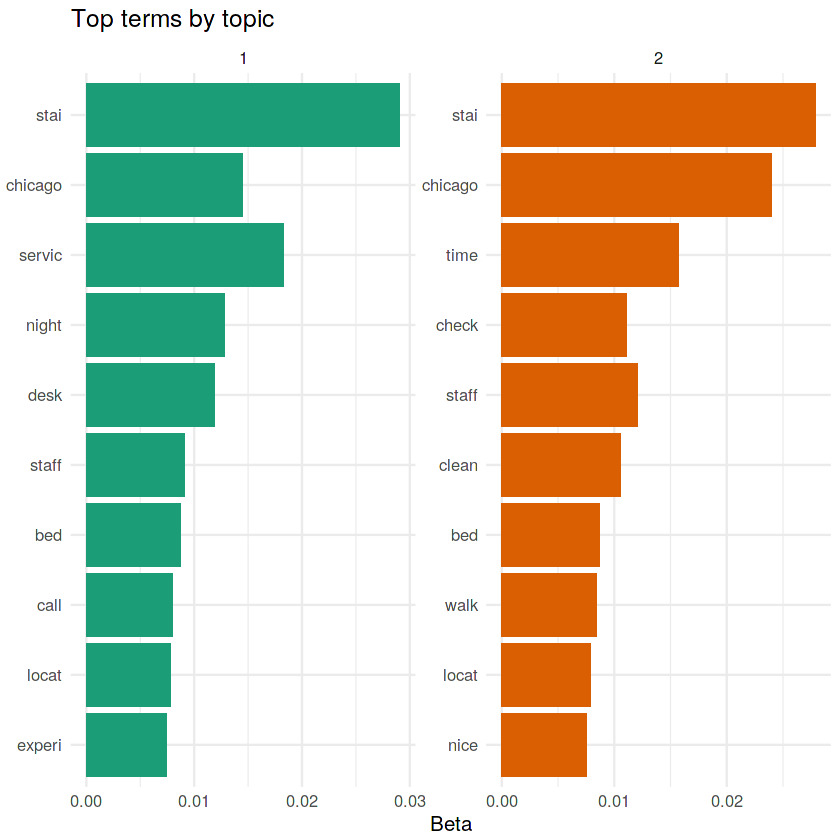

In [71]:

# plotting the top ten terms in hotel reviews by topic

top_terms_by_topic_LDA(cleaned_documents$terms, number_of_topics = 2)

# Topic modeling(TF-IDF)


In [72]:

top_terms_by_topic_tfidf <- function(text_df, text_column, group_column, plot = T){

    group_column <- enquo(group_column)
    text_column <- enquo(text_column)
    
    words <- text_df %>%
      unnest_tokens(word, !!text_column) %>%
      count(!!group_column, word) %>% 
      ungroup()

    total_words <- words %>% 
      group_by(!!group_column) %>% 
      summarize(total = sum(n))

    words <- left_join(words, total_words)

    tf_idf <- words %>%
      bind_tf_idf(word, !!group_column, n) %>%
      select(-total) %>%
      arrange(desc(tf_idf)) %>%
      mutate(word = factor(word, levels = rev(unique(word))))
    
    if(plot == T){
       
        group_name <- quo_name(group_column)
        
        tf_idf %>% 
          group_by(!!group_column) %>% 
          top_n(10) %>% 
          ungroup %>%
          ggplot(aes(word, tf_idf, fill = as.factor(group_name))) +
          geom_col(show.legend = FALSE) +
          labs(x = NULL, y = "tf-idf") +
          facet_wrap(reformulate(group_name), scales = "free") +
          coord_flip()
    }else{
        return(tf_idf)
    }
}

Joining, by = "deceptive"
Selecting by tf_idf


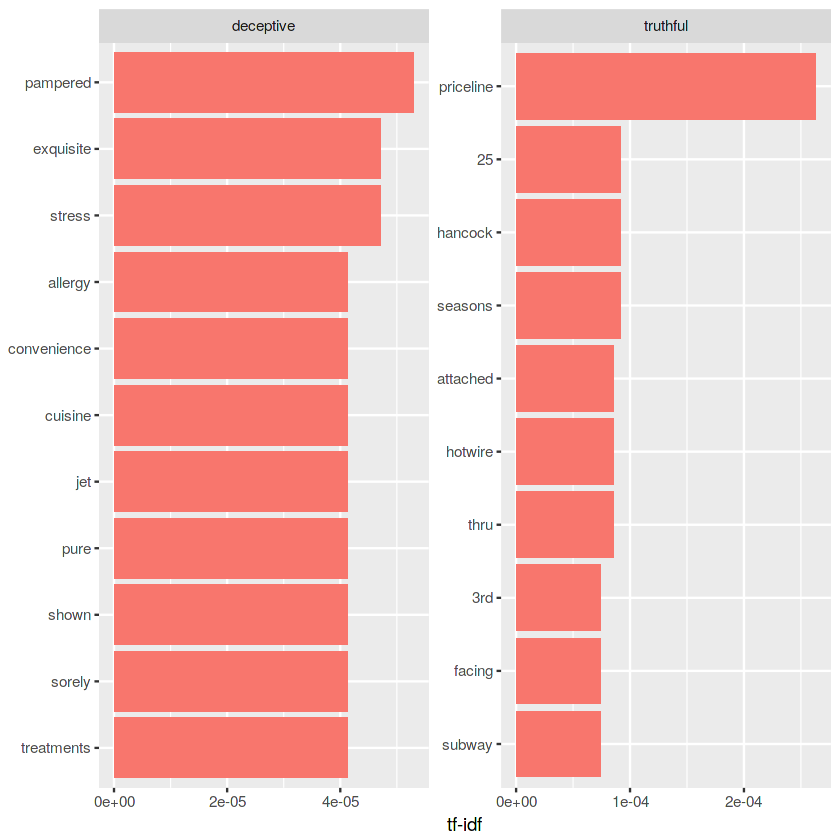

In [73]:
# plotting deceptive reviews
top_terms_by_topic_tfidf(text_df = reviews, 
                         text_column = text, 
                         group_column = deceptive,
                         plot = T) 

Joining, by = "polarity"
Selecting by tf_idf


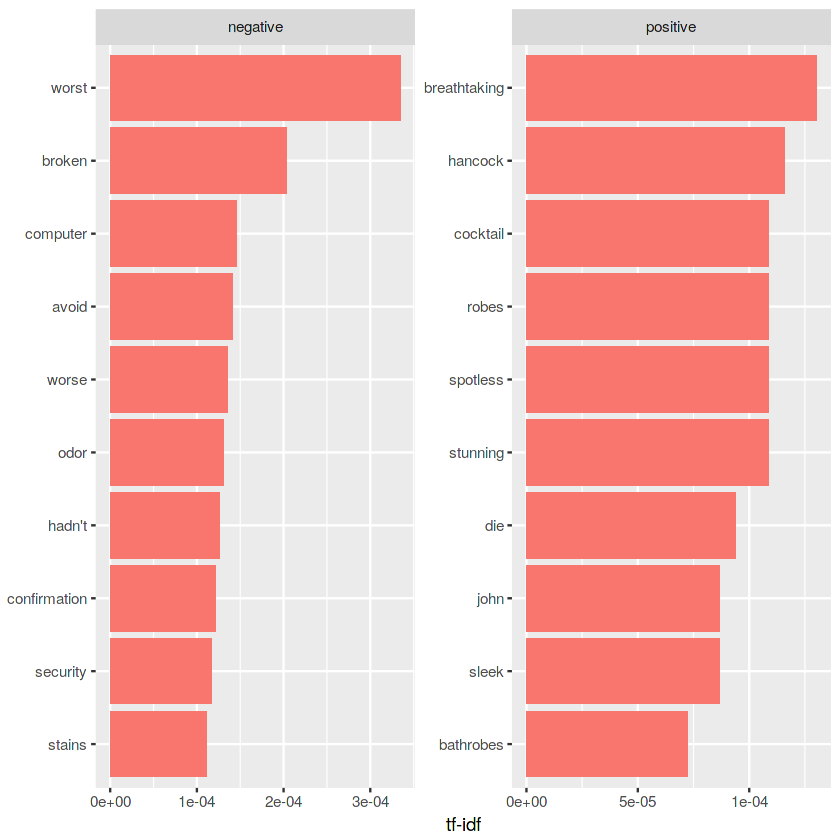

In [74]:
# plotting postive and negative reveiws
top_terms_by_topic_tfidf(text_df = reviews, 
                         text_column = text, 
                         group = polarity, 
                         plot = T)